Dask Approach to Non-SQL PTM Queries
--

v01: move away from classes, try to organize the computation 
primarily in dask.

In [2]:
import postproc_dask as post
import six

In [3]:
try:
    client.close()
except NameError:
    pass

In [4]:
import multiprocessing.popen_spawn_posix #  https://github.com/dask/distributed/issues/4168
import dask
import dask.dataframe as dd
import dask.bag as db

from dask.distributed import Client
client=Client(n_workers=8,threads_per_worker=1)
client.cluster

In [5]:
import matplotlib.pyplot as plt
import conc_figure
import six
import stompy.plot.cmap as scmap
from stompy.spatial import proj_utils
from matplotlib import cm
cmap=cm.CMRmap_r
cmap=scmap.cmap_clip(cmap,0.03,1.0)

%matplotlib notebook

In [6]:
import os
import glob
import numpy as np
import pandas as pd
import xarray as xr
import re

from stompy.grid import unstructured_grid
from stompy import utils, memoize
from stompy.model.fish_ptm import ptm_config, ptm_tools
from stompy.model.suntans import sun_driver
from scipy.stats import spearmanr

import stompy.plot.cmap as scmap
from scipy import stats
import seaborn as sns
turbo=scmap.load_gradient('turbo.cpt')

Overall Process
===

1. SUNTANS hydro runs
2. SUNTANS average output
3. ptm-formatted average output
4. PTM runs
5. Load data

The top-level query is something like *generate a map of concentrations for...*

filter on:
 - sources $x$
 - settling classes $y$
 - vertical positions $z$
 - horizontal positions $h$

weighted by

 - loading data 
 - age
 
mapped by one of ...

 - bounding box
 - put on hydro grid
 - put on regular grid

and possibly smoothed.

In [7]:
# Experiment level configuration -- small, all python native data.
cfg=dict(
    ptm_base_dir="/opt2/sfb_ocean/ptm/all_source_022b",
    sun_base_dir="/opt2/sfb_ocean/suntans/runs",
    ptm_output_interval=np.timedelta64(1,'h')
)
cfg['ptm_run_patt']=os.path.join(cfg['ptm_base_dir'],"chunk??","20??????")
cfg['sun_patt']=os.path.join(cfg['sun_base_dir'],"merged_022_20??????")

ptm_run_paths=glob.glob(cfg['ptm_run_patt'])
ptm_run_paths.sort()
cfg['ptm_run_paths']=ptm_run_paths

sun_paths=glob.glob(cfg['sun_patt'])
sun_paths.sort()
cfg['sun_paths']=sun_paths

In [8]:
# Load the grid into... grid
hydro_path=sun_paths[0]
ptm_ds=xr.open_dataset(os.path.join(hydro_path,"ptm_average.nc_0000.nc"))
grid=unstructured_grid.UnstructuredGrid.read_ugrid(ptm_ds,dialect='fishptm')
ptm_ds.close()   

# distribute to workers ahead of time.
grid_d=client.scatter(grid)
cfg['grid_d']=grid_d # too far?

In [9]:
# So far this is only used locally.  Slow to compute (15s)
Msmooth=grid.smooth_matrix()
Msmooth_K=grid.smooth_matrix(K=100*np.ones(grid.Nedges()))

INFO:utils:61919/99089
INFO:utils:60249/99089


In [10]:
# Or could make this delayed and have it execute on each client?
load_data_d=client.scatter(post.get_load_data())
cfg['load_data_d']=load_data_d

In [11]:
# Hydro timestamps
cfg['hydro_timestamps']=post.load_hydro_timestamps(sun_paths)

In [12]:
bc_ds_d=client.scatter(post.bc_ds(cfg=cfg))
cfg['bc_ds_d']=bc_ds_d

In [13]:
areas=grid.cells_area()    

In [14]:
# Set this a bit early, as it controls cache location which 
# is needed for some testing.
cfg['manta_out_dir']="manta_sets_20210708d"

# now the 021b runs.
# c suffix: use tighter -0.095 z filter.
# 20200227: start of v03
# 20200302: start of v04
# 20200305: try larger window -- extra 24 hours in both directions.
# 20200312: new sources in ptm data, with v02 stormwater concs.
# 20200330: more new sources.
# 20210210a: dask code, new hydro, new ptm. new year.
# 20210317a: new ptm runs with no SJ loss...
#            has the w_s bug
# 20210317b: fixed w_s bug
# 20210317c: switch to weathered loads
# 20210708c: including beaching and deposition counts.
os.makedirs(cfg['manta_out_dir'],exist_ok=True)

Beaching and Deposition
---

Beaching and deposition seem to be more likely candidates for scale offsets 
than sinking.

In [30]:
# Testing query_group_particles:
six.moves.reload_module(post)
run=cfg['ptm_run_paths'][0]
grps=post.run_to_group_paths(run)
grp=grps[0]
load_data=post.get_load_data()
bc_ds=post.bc_ds(cfg=cfg)

post.query_group_particles(grp,
                           dict(t_min=np.datetime64('2017-06-30'),
                                t_max=np.datetime64('2017-07-04'),
                                age_max=np.timedelta64(60,'D')),
                           load_data=load_data,
                           bc_ds=bc_ds)

,id,x0,x1,x2,active,time,cell,z_surface,group,rel_time,mp_per_liter,m3_per_particle,mp_per_particle
0,1,573839.214530,4.157490e+06,-6.566147,1,2017-06-30,8317,-3.116791,/opt2/sfb_ocean/ptm/all_source_022b/chunk00/20...,2017-06-20 00:00:00,0.006288,153.930380,967.903122
1,2,576622.008212,4.152236e+06,-12.056881,1,2017-06-30,40813,-3.098871,/opt2/sfb_ocean/ptm/all_source_022b/chunk00/20...,2017-06-20 00:00:00,0.006288,153.930380,967.903122
2,3,569839.499294,4.161945e+06,-7.572867,1,2017-06-30,39151,-3.140814,/opt2/sfb_ocean/ptm/all_source_022b/chunk00/20...,2017-06-20 00:00:00,0.006288,153.930380,967.903122
3,4,577047.964137,4.151897e+06,-19.367282,1,2017-06-30,40844,-3.098205,/opt2/sfb_ocean/ptm/all_source_022b/chunk00/20...,2017-06-20 00:00:00,0.006288,153.930380,967.903122
4,5,572253.637865,4.159840e+06,-5.754190,1,2017-06-30,23357,-3.127188,/opt2/sfb_ocean/ptm/all_source_022b/chunk00/20...,2017-06-20 00:00:00,0.006288,153.930380,967.903122
...,...,...,...,...,...,...,...,...,...,...,...,...,...
232795,2396,576443.197861,4.157085e+06,-5.455726,1,2017-07-04,8470,-4.195541,/opt2/sfb_ocean/ptm/all_source_022b/chunk00/20...,2017-06-29 23:00:00,0.006288,143.863741,904.604822
232796,2397,576627.179900,4.157627e+06,-5.475207,1,2017-07-04,40557,-4.194823,/opt2/sfb_ocean/ptm/all_source_022b/chunk00/20...,2017-06-29 23:00:00,0.006288,143.863741,904.604822
232797,2398,576069.171648,4.157066e+06,-6.083315,1,2017-07-04,23189,-4.192039,/opt2/sfb_ocean/ptm/all_source_022b/chunk00/20...,2017-06-29 23:00:00,0.006288,143.863741,904.604822
232798,2399,575365.755678,4.157029e+06,-5.929114,1,2017-07-04,13925,-4.184586,/opt2/sfb_ocean/ptm/all_source_022b/chunk00/20...,2017-06-29 23:00:00,0.006288,143.863741,904.604822


In [ ]:
df=post.particles_for_date("2017-10-21 00:00:00",cfg=cfg)

In [ ]:
len(df)

In [33]:
# Choose a particle, and count its encounters with the bed and the shore.
grp # Alameda down50000

info=xr.open_dataset(grp+"-v00.nc")

pid=10

particles=post.query_group_particles(grp,
                           dict(#t_min=np.datetime64('2017-06-30'),
                                #t_max=np.datetime64('2017-07-04'),
                                age_max=np.timedelta64(60,'D')),
                           load_data=load_data,
                           bc_ds=bc_ds)

In [37]:
grid.cells.dtype

dtype([('edges', '<i4', (4,)), ('nodes', '<i4', (4,)), ('_center', '<f8', (2,)), ('mark', '<i4'), ('_area', '<f8'), ('deleted', '?'), ('cell_depth', '<f8'), ('Mesh2_face_edges', '<i4', (4,)), ('Mesh2_face_depth', '<f8'), ('Mesh2_face_bc', '<i4'), ('z_bed', '<f8')])

<IPython.core.display.Javascript object>


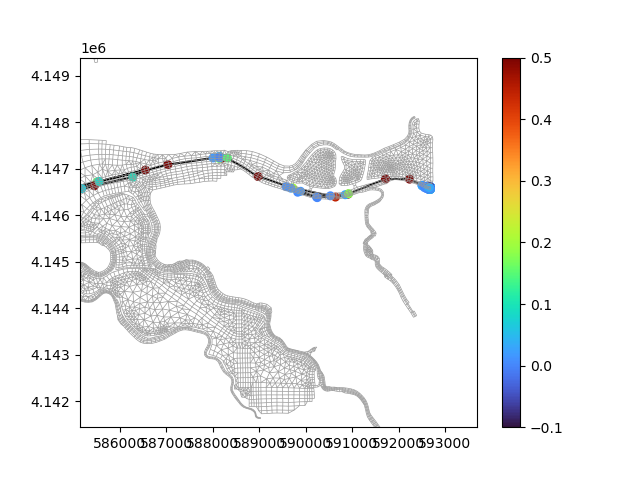

(335896.809213, 622757.585107, 3970068.94815, 4307931.05185)

In [43]:
# len(particles) # 3M
particle=particles[ particles['id']==10 ]
len(particle)

z_bed=grid.cells['z_bed'][particle['cell']]
zab=particle['x2']-z_bed

plt.figure()
grid.plot_edges(lw=0.5,color='0.6')
plt.plot(particle['x0'],particle['x1'],'k-',zorder=0)
scat=plt.scatter(particle['x0'],particle['x1'],30,zab,cmap='turbo',zorder=1)
scat.set_clim([-0.1,0.5])
plt.colorbar(scat)
plt.axis('tight')
plt.axis('equal')

# zab goes down to 2e-5.


<IPython.core.display.Javascript object>


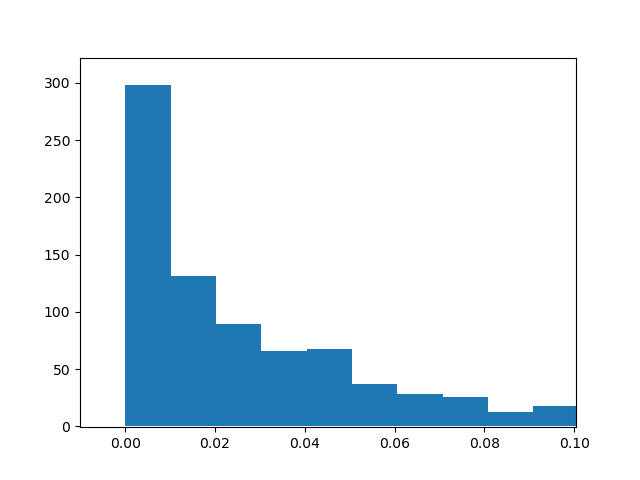

(array([298., 131.,  89.,  66.,  68.,  37.,  28.,  26.,  13.,  18.,  14.,
         15.,  12.,  17.,   7.,  12.,  11.,   5.,  18.,   8.,  11.,  15.,
          9.,   8.,   9.,   5.,   5.,   8.,   2.,  11.,  10.,   2.,   3.,
          6.,   1.,   7.,   6.,   1.,   6.,   5.,   0.,   6.,   4.,   7.,
          6.,   4.,   3.,   5.,   4.,   5.,   2.,   6.,   5.,   1.,   4.,
          6.,   3.,   6.,   4.,   7.,   4.,   4.,   0.,   1.,   3.,   3.,
          5.,   2.,   4.,   3.,   4.,   1.,   5.,   3.,   5.,   3.,   4.,
          3.,   2.,   4.,   4.,   7.,   2.,   2.,   2.,   4.,   1.,   2.,
          2.,   3.,   6.,   8.,   0.,   3.,   2.,   3.,   0.,   1.,   3.]),
 array([0.        , 0.01010101, 0.02020202, 0.03030303, 0.04040404,
        0.05050505, 0.06060606, 0.07070707, 0.08080808, 0.09090909,
        0.1010101 , 0.11111111, 0.12121212, 0.13131313, 0.14141414,
        0.15151515, 0.16161616, 0.17171717, 0.18181818, 0.19191919,
        0.2020202 , 0.21212121, 0.22222222, 0.23232323, 0.24

In [48]:
plt.figure()
plt.hist(zab,bins=np.linspace(0,1,100))

In [44]:
zab.min()

2.5212875095270704e-05

Next steps
--


1. Recreate some of the figures from before, including on-grid smoothing.  
  a. Sample plot: from the powerpoint. 2017-08-30 to 2017-09-14. Surface particles
     max age of 10 days.   *This plot is similarish -- not exactly the same but close
     enough to rule out fundamental errors*
2. Pull out manta samples as before. Maybe skip putting it on the grid, just
   query a radius.
  a. Implement in this notebook
  b. Move all of this to a module.

In [ ]:
ll2utm=proj_utils.mapper('WGS84','EPSG:26910')
# Load the manta data, clean it up
manta_fn='manta_summary-v03.csv'
manta=pd.read_csv(manta_fn)
manta.head()

In [ ]:
godwin_offset_h=post.godwin_offset_h
godwin=post.godwin

In [ ]:
len(cfg['ptm_run_paths'])

In [ ]:
def predict_mantas_multi(manta,taus,
                         Msmooths=[Msmooth],
                         steps=[30],
                         storm_factors=[0.05],
                         cfg=cfg):
    # manta: pd.DataFrame 
    # tau: np.timedelta64 giving e-folding time scale
    # of loss.
    # storm_factor: scale stormwater concentrations by this
    #  factor.
    preds=[]
    
    # Force mantas to be sorted, so that data from the same day
    # is grouped together.
    manta=manta.sort_values('DATE')
    last_DATE=None
    df=None

    for idx,rec in utils.progress(manta.iterrows()):
        print(idx)
        # since we're just pulling out whole days, cache by day.
        # and pull through the end of that day
        # 5s, all in read_parquet
        if rec.DATE==last_DATE:
            pass
        else:
            df=post.particles_for_date(rec.DATE,cfg=cfg)
            last_DATE=rec.DATE

        # Trawl-specific processing:
        # Pull subset of cells
        # add a cell weighting, and a time weighting for the tidal filter
        for Msmooth_i,Msmooth in enumerate(Msmooths):
            print(f"  smooth: {Msmooth_i}")
            for step in steps:
                print(f"    steps: {step}")
                cells,weights=post.rec_to_cell_weights(rec,areas=areas,grid=grid,
                                                       Msmooth=Msmooth,smooth=step,thresh=1e-5)
                df_spatial=pd.DataFrame(dict(cell=cells,weight_spatial=weights)).set_index('cell')
                # 1.3s. selecting a subset of rows, and adding a column with spatial weight.
                # Using a dictionary might get this down to 60% of original
                # going through numpy  might get down to 40% of original.
                if 0:
                    tdf=df.join(df_spatial,on='cell',how='inner')
                else:
                    # trying numpy approach
                    df_spatial_sort=df_spatial.sort_index()
                    space_cell=df_spatial_sort.index.values
                    space_weight=df_spatial_sort['weight_spatial'].values
                    df_cell=df.cell.values
                    df_idx=np.searchsorted(space_cell,df_cell).clip(0,len(space_cell)-1)
                    sel=space_cell[df_idx]==df_cell
                    tdf=df[sel].copy()
                    tdf['weight_spatial']=space_weight[df_idx[sel]]                    

                t_sample=np.datetime64(rec['DATE'])    
                t_center = t_sample+np.timedelta64(8,'h') + np.timedelta64(12,'h')
                delta_hours=((tdf['time']-t_center)/np.timedelta64(1,'h')).astype(np.int32)
                weight_time=godwin[delta_hours+godwin_offset_h]
                age=tdf['time'] - tdf['rel_time']
    
                for storm_factor in storm_factors:
                    print(f"      storm_factor: {storm_factor}")
                    group_weight=post.group_weights(tdf,storm_factor)

                    for tau in taus:
                        tau_s=tau/np.timedelta64(86400,'s')
                        print(f"        tau={tau_s} days")
                        pred=dict(idx=idx,storm_factor=storm_factor,tau=tau,step=step,
                                  Msmooth_i=Msmooth_i)
                        pred['idx']=idx

                        if tau_s>0:
                            decay=np.exp( -age/tau )
                        else:
                            decay=1.0
                        weights=tdf['weight_spatial']*weight_time*decay*group_weight

                        # tdf['mp_per_particle'] # the number of physical particles represented by the virtual particle
                        #   This is the contribution from this one
                        #   virtual particle the cell concentration
                        C=( weights * tdf['mp_per_particle'] / areas[tdf['cell']] ).sum()
                        pred['C_model']=C
                        preds.append(pred)

    df_pred=pd.DataFrame(preds)
    manta_pred=df_pred.join(manta,on='idx')
    return manta_pred

In [ ]:
def metrics(grp):
    obs=grp['part_per_m2_nofiber'].values
    mod=grp['C_model'].values
    
    skill={}
    skill['rho'],skill['rho_p']=spearmanr(obs, mod)
    skill['norm_std']=mod.std() / obs.std()
    skill['norm_mag']=mod.mean() / obs.mean()
    skill['rel_std_obs']=obs.std() / obs.mean()
    skill['rel_std_mod']=mod.std() / mod.mean()
    
    # log-transformed
    min_nonzero=obs[obs>0].min()
    r_log=np.corrcoef(np.log(obs.clip(min_nonzero)),
                      np.log(mod.clip(min_nonzero)))[0,1]
    skill['r_log']=r_log
    
    # Same but drop top/bottom 2 outliers:
    obs_rank=np.argsort(np.argsort(obs))
    sel=(obs_rank>2)&(obs_rank<len(obs)-2)
    r=np.corrcoef(obs[sel], mod[sel])[0,1]
    skill['r_sub']=r
    
    skill['norm_std_sub']=mod[sel].std() / obs[sel].std()
    skill['norm_mag_sub']=mod[sel].mean() / obs[sel].mean()
    skill['rel_std_obs_sub']=obs[sel].std() / obs[sel].mean()
    skill['rel_std_mod_sub']=mod[sel].std() / mod[sel].mean()

    return pd.Series(skill)
   

In [ ]:
if 0:
    # Evaluate effect of smoothing on correlation metrics
    # This one testing evaluation of multiple smooths, steps,
    # tau, etc. in one call.
    taus=[np.timedelta64(int(25*86400),'s')]
    Msmooths=[Msmooth,Msmooth_K]
    mtypes=['grid','constant']
    steps=[0,-10,-100,-1000,-10000,-100000]

    manta_pred=predict_mantas_multi(manta,taus=taus,
                                    Msmooths=Msmooths,
                                    steps=steps,
                                    storm_factors=[1.0])
    manta_pred['Msmooth_label']=[ mtypes[i] for i in manta_pred['Msmooth_i'].values]

    manta_pred.groupby(['Msmooth_label','step','tau','storm_factor']).apply(metrics)

    taus=[np.timedelta64(int(d*86400),'s') for d in [1,2,5,10,20,30,45,60]]
    Msmooths=[Msmooth]
    mtypes=['grid']
    steps=[-10000]

    manta_pred_tau=predict_mantas_multi(manta,taus=taus,
                                        Msmooths=Msmooths,
                                        steps=steps,
                                        storm_factors=[1])
    manta_pred_tau['Msmooth_label']=[ mtypes[i] for i in manta_pred_tau['Msmooth_i'].values]

    manta_pred_tau.groupby(['Msmooth_label','step','tau','storm_factor']).apply(metrics)

In [ ]:
# Master set of predictions
taus=[np.timedelta64(int(d*86400),'s') for d in [5,10,20,30,60]]
Msmooths=[Msmooth,Msmooth_K]
mtypes=['grid','constant']
steps=[0,-10,-1000,-10000,-100000]
storm_factors=[0.,0.01,0.05,0.2,1.0]

In [ ]:
manta_pred_master=predict_mantas_multi(manta,taus=taus,
                                       Msmooths=Msmooths,
                                       steps=steps,
                                       storm_factors=storm_factors)
manta_pred_master['Msmooth_label']=[ mtypes[i] for i in manta_pred_master['Msmooth_i'].values]

manta_pred_master.groupby(['Msmooth_label','step','tau','storm_factor']).apply(metrics)

In [ ]:
manta_pred_master['tau']=manta_pred_master['tau']/np.timedelta64(86400,'s')
manta_pred_master.to_parquet('manta_pred_master.parquet')

In [ ]:
all_metrics=manta_pred_master.groupby(['Msmooth_label','step','tau','storm_factor']).apply(metrics)

In [ ]:
# Best overall rho:
#  tau=5, storm=1, grid smooth, step=-100000 => rho=0.74
#  insensitive to tau. mag still something like 14x too large for tau=60,
#  interestingly, even with tau=5, magnitude still 7x too large.
all_metrics.sort_values('rho',ascending=False).head(10)

In [ ]:
# so an r_log of 0.717 is r2
all_metrics['r2_log']=all_metrics['r_log']**2
all_metrics.sort_values('r_log',ascending=False).head(10)

In [ ]:
# Best r_sub is also grid smoothed, step=-100000, but now
# tau=60.0. Again, not very sensitive to tau or storm_factor.
all_metrics.sort_values('r_sub',ascending=False).head(10)

In [ ]:
# Best magnitudes, including obs. outliers?
# This is all the place. Chooses some very noisy options,
# probably just happenstance to get close.  All pretty low rho
# and r_sub.
all_metrics['norm_mag_err']=np.abs(all_metrics['norm_mag']-1)
all_metrics.sort_values('norm_mag_err').head(10)

In [ ]:
# These mostly toss stormwater entirely.
# Again, poor rho and r_sub values.
all_metrics['norm_mag_sub_err']=np.abs(all_metrics['norm_mag_sub']-1)
all_metrics.sort_values('norm_mag_sub_err').head(10)

In [ ]:
fig=plt.figure(figsize=(6,2.5))
for smooth_type in ['grid','constant']:
    df_sub
    x=df_skill_smooth['smooth']

plt.plot(df_skill['tau_d'],df_skill['r'],label='Pearson $r$, full')
plt.plot(df_skill['tau_d'],df_skill['r_sub'],label='Pearson $r$, sub')

plt.plot(df_skill['tau_d'],df_skill['rho'],label=r'Spearman $\rho$, full')
plt.plot(df_skill['tau_d'],df_skill['rho_sub'],label=r'Spearman $\rho$, sub')

plt.plot(df_skill['tau_d'],df_skill['rlog'],label='Pearson $r$, full, log transform')
plt.plot(df_skill['tau_d'],df_skill['rlog_sub'],label='Pearson $r$, sub, log transform')
plt.legend(loc='upper left',bbox_to_anchor=[1.02,1.0],frameon=False)
plt.xlabel('Decay time scale (d)')
plt.axis(ymin=0,xmin=0)
fig.tight_layout()

Previously I got these results:
* Pearson $r$ is maximized by omitting any decay, as in $\tau\rightarrow\infty$
* Spearman $\rho$ is maximized by having a very short decay, 15h
* Log-transformed Pearson $r$ is maximized at around 25 days.

If I remove the top 2 and bottom 2 observed values, then Pearson
values come up to a level similar to log-pearson. Pearson
is still maximized by having little or no decay.

Re-running this, I don't see the local max in Pearson of the
log-transformed data.

What does it mean that Pearson correlation is highest at long decay
time scales, while Spearman is highest at short decay scales?

At short decay time scales, many of the predicted concentrations end up being
very small, substantially smaller than the observations even with no scaling
of the loads. This is penalized by Pearson, but for Spearman this correlates with
the lower concentration in the ocean compared to the estuary, and thus increases
skill.


In [ ]:
# What is Spearman just for getting two populations split correctly?
# Similar to what I get (for an offset that nearly makes the populations
# distinct)
# If the populations are different by a scale, then it takes a pretty 
# large scale (30?) to get a spearman of 0.7.

N=60
obs=np.random.random(N)
mod=np.random.random(N)

#off=0.8
#obs[:N//2]+=off
#mod[:N//2]+=off

fac=30
obs[:N//2]*=fac
mod[:N//2]*=fac

rho,p=spearmanr(obs,mod)
rho

In [ ]:
# Group samples - Central Bay, North Bay, South Bay, NMS.
def loc_to_region(s):
    if s.startswith('SPB') or s.startswith('SUB'): return 'NB'
    if s.startswith('SB') or s.startswith('LSB'): return 'SB'
    if s.startswith('GFNMS') or s.startswith('MBNMS') or s.startswith('CBNMS'): 
        return 'NMS'
    if s.startswith('CB') or s=='SFBay': return 'CB'
    raise Exception("No match for %s"%s)
    
def analyze_medians(df):
    dfm=df.loc[:,['region','obs','predicted']].melt(id_vars=['region']).set_index(['region','variable'])

    dfm.sort_index(inplace=True)

    def p_total(f):
        # Maximize the combined median test
        p_tot=1.0
        for region in ['CB','NB','SB','NMS']:
            obs=dfm.loc[ (region,'obs'), 'value']
            mod=f*dfm.loc[ (region,'predicted'), 'value']
            # is it better to choose just the modeled data where the observation
            # is valid?
            stat,p,M,cont=stats.median_test( obs[np.isfinite(obs)] ,
                                             mod[np.isfinite(mod)] )
            p_tot*=p
        return p_tot

    def cost(p):
        return -p_total( 10**p )

    from scipy.optimize import brute

    best=brute(cost,[[-4,1]],Ns=51)
    scale=10**best[0]
    p_tot=p_total(scale)
    print(f"P-total: {p_tot:.3f}  with scale: {1/scale:5f}")
    return p_tot,scale

In [ ]:
# Pulling in the old code from median comparisons.

manta_field='part_per_m2_nofiber'

for tau_d in [50]: # [0.5,1,1.5,2.,3,4,5,6,8,10,12,15,20,25,30,35,40,45,50,55,60]:
    print(f"Tau: {tau_d} days")
    tau=np.timedelta64(int(tau_d*86400),'s')
    df=predict_mantas(manta,tau,storm_factor=0.01)
    
    df=df[ df[manta_field].notnull() ].copy()
    
    regions=df['region']=df['SAMPLE LOCATION'].apply(loc_to_region)
    df=df.rename(columns={manta_field:'obs','C_model':'predicted'}).loc[:,['region','obs','predicted']]

    # Scale gets optimized to find the best nonparametric match
    p_tot,scale=analyze_medians(df)

    # This is not rigorous!
    obs_mag=1.0
    pred_mag=1/scale
    
    df['obs_frac']=df['obs'] / obs_mag
    df['pred_frac']=df['predicted'] / pred_mag

    dfm=df.loc[:,['region','obs_frac','pred_frac']].melt(id_vars=['region'])

    fig,ax=plt.subplots(1,1)# ,figsize=(10,3))
    sns.boxplot(x='region',y='value',hue='variable',data=dfm,fliersize=0,whis=0,
                ax=ax,bootstrap=1000)
    ax.axis(ymax=0.35,ymin=0)
    ax.legend(ax.artists,['Observed',f'Predicted/{pred_mag:.2f}'],loc='upper right')
    ax.set_ylabel('Particle m$^{-2}$')
    ax.set_xlabel('Region')
    
    ax.set_title(f'Tau={tau_d} days  $\\Pi \\rho$={p_tot:.2f}')
    df2=dfm.set_index(['region','variable'])
    p_tot=1.0
    for region in ['CB','NB','SB','NMS']:
        stat,p,M,cont=stats.median_test( df2.loc[ (region,'obs_frac'), 'value'] ,
                                         df2.loc[ (region,'pred_frac'), 'value'] )
        p_tot*=p
    print(f"{tau_d} days: ampl. error: {pred_mag/obs_mag:.3f} Median test net p: {p_tot:.5f}")
    
    print()
    fig.savefig(f'manta_comp_v05-tau{tau_d:.1f}.png',dpi=200)
    #break

In [ ]:
#plt.figure()
#plt.plot( df2.loc[('NB','obs_frac'),'value'], 'ro')
#plt.plot( df2.loc[('NB','pred_frac'),'value'],'go')

# Just 6 values...
display(df2.loc[('NB','obs_frac'),'value'])
display(df2.loc[('NB','pred_frac'),'value'])


In [ ]:
# For each manta sample, make a plot showing the conc. distribution at that time
# to debug what's up with the north bay samples:

tau_d=8
fac=39.81 # this is from analyze_medians.
six.moves.reload_module(conc_figure)

fig_dir=f"sample_wise_tau{tau_d}"
if not os.path.exists(fig_dir):
    os.makedirs(fig_dir)

tau=np.timedelta64(int(tau_d*86400),'s')
for idx,rec in manta.iterrows():
    print(idx)
    img_fn=os.path.join(fig_dir,f"sample-{idx}.png")
    fig,axs=plt.subplots(1,2,figsize=(11,7))
    fig.subplots_adjust(left=0,right=1,top=1,bottom=0,wspace=0.02)
    df=particles_for_date(rec.DATE).copy()

    age=df['time'] - df['rel_time']
    decay=np.exp( -age/tau ) 
    
    # No spatial weighting, but need the godin filter weights
    t_sample=np.datetime64(rec.DATE)
    # Noon, local, day of sampling
    t_center = t_sample+np.timedelta64(8,'h') + np.timedelta64(12,'h')
    delta_hours=((df['time']-t_center)/np.timedelta64(1,'h')).astype(np.int32)
    weight_time=godwin[delta_hours+godwin_offset_h]

    df['count']=weight_time * decay * df['mp_per_particle'] 

    weight=weight_time * decay * df['mp_per_particle'] 
        
    ds_conc=post.particles_to_conc(df,grid,'count')

    ds_smooth=ds_conc.copy()
    for _ in range(30):
        ds_smooth['conc']=('cell',), Msmooth.dot(ds_smooth.conc.values)
    
    cell=grid.select_cells_nearest([rec.x,rec.y])
        
    zoom=conc_figure.BayConcFigure.zoom
    
    if ( (rec.x>zoom[0]) and
        (rec.x<zoom[1]) and
        (rec.y>zoom[2]) and
        (rec.y<zoom[3])):
        FigCls=conc_figure.BayConcFigure
        FigCls.cax_loc=[0.82,0.25,0.03,0.35] # normalized to axis 
    else:
        FigCls=conc_figure.CoastalConcFigure
        
    for ds,ax in zip([ds_smooth,ds_conc],axs):
        cf=FigCls(ds,fig=fig,ax=ax,grid=grid)
        cf.ax.plot([rec.x],[rec.y],'k+')
        conc_pred=ds.conc.isel(cell=cell).item()
        conc_pred=conc_pred / fac

        cf.ax.text(rec.x,rec.y,
                   f"part_per_m2_nofiber\n obs={rec.part_per_m2_nofiber:.2e}\npred={conc_pred:.2e}")

        cf.ax.text(0.01,0.95,f"Manta sample: {rec.SampleID}",transform=cf.ax.transAxes,va='top')
    fig.savefig(img_fn,dpi=200)


In [ ]:
ds_conc

Next Steps
-- 

2. Think through how to present the comparisons. *ish*
3. What can we infer from these patterns? *ish*
4. Results appear worse, in terms of likelihood, than 
   for the old runs, probably driven by NB. Looks like 
   I am underpredicting NB.  Sample by sample, not terribly
   obvious what's up.  It's just 6 samples.
4. Would having different loss coefficients for WW and SW be worth
   attempting?
    - This is worth trying, and try maximizing the pearson with outliers
      tossed.
    - Does not make much difference.
5. Is it worth following a similar analysis to previously, lumping
   samples into embayments? *Blindly running that same code, it suggests
   that decay times >=20 days are best, with little difference beyond there.*
   I'm getting smaller net prob. values, though, and it seems to be driven
   by NB being underpredicted (relatively speaking) in the new runs. Any chance
   I'm missing something in the north? The one map plot above looks okay, but compare
   for wet weather.
   
What about applying a much more aggressive smoothing, going implicit?

In [ ]:
six.moves.reload_module(conc_figure)

conc_figure.BayConcFigure(conc_ds,grid=grid,cmap=cmap)

Closer look at distributions
---

Tau constant at 25:

The predictions with the best spearman were grid smoothing -10000.
But the log-normal shape here is pretty terrible.

A moderately better log-normal comes up with no smoothing.

The best match in distribution is with no smoothing, tau=10,
storm_factor 0.05 or 0.01.

Given the amount of smoothing already taking place in time,
and how much the results here are affected by smoothing in
space, it may not be a great comparison.

In [ ]:
import seaborn as sns
import scipy.stats

fig,axs=plt.subplots(2,1)

mp=manta_pred_master
sel_tau=mp.tau==10
sel_smooth=mp.Msmooth_label=='constant'
sel_step=mp.step==0
sel_storm=mp.storm_factor==0.01
sel=sel_tau & sel_smooth & sel_step & sel_storm
df=manta_pred_master[sel]

nz=df['part_per_m2_nofiber']>0
kde=False
ret=sns.histplot(df['part_per_m2_nofiber'][nz],
                 log_scale=True,kde=kde,bins=25,ax=axs[0])
shape,loc,scale=stats.lognorm.fit(df['part_per_m2_nofiber'][nz],floc=0)
x=10**np.linspace(-5,2,300)
ln_pred=stats.lognorm.pdf(x,shape,loc=loc,scale=scale)
axs[0].plot(x,x*ln_pred*nz.sum()/2,color='tab:orange',label='Log-normal')

# ---- same, for model output
pred=df['C_model'].values
pred=pred[pred>0]

ret=sns.histplot(pred,log_scale=True,kde=kde,bins=25,ax=axs[1])
m_shape,m_loc,m_scale=stats.lognorm.fit(pred,floc=0)
ln_pred=stats.lognorm.pdf(x,m_shape,loc=m_loc,scale=m_scale)
axs[1].plot(x,x*ln_pred*nz.sum()/2,color='tab:orange',label='Log-normal')

print("Obs scale: ",scale)
print("Mod scale: ",m_scale)
print("Obs shape: ",shape)
print("Mod shape: ",m_shape)

In [ ]:
mp=manta_pred_master
sel_tau=mp.tau==60
sel_smooth=mp.Msmooth_label=='grid'
sel_step=mp.step==-100000
sel_storm=mp.storm_factor==1.0
sel=sel_tau & sel_smooth & sel_step & sel_storm
df=manta_pred_master[sel]

import statsmodels.formula.api as smf
from scipy.stats import spearmanr



In [ ]:
# statsmodels on log-transform
n_low=n_high=0
obs_rank=np.argsort(np.argsort(df['part_per_m2_nofiber']))
obs_sel=(obs_rank>=n_low) & (obs_rank<len(df)-n_high)
mod_rank=np.argsort(np.argsort(df['C_model']))
mod_sel=(mod_rank>=n_low) & (mod_rank<len(df)-n_high)

sel_nz=(df['part_per_m2_nofiber']>0)&(df['C_model']>0).values
sel=obs_sel&mod_sel&sel_nz
print(f"N={len(rank)}  Nsel={sel.sum()}")

data=df[sel].copy()
data['log_mod']=np.log(data['C_model'])
data['log_obs']=np.log(data['part_per_m2_nofiber'])

res=smf.ols(formula='log_mod ~ log_obs', data=data).fit()
res.summary()

In [ ]:
rho,rho_p=spearmanr(data['C_model'],data['part_per_m2_nofiber'])
print(f"Spearman:  rho={rho}  p-value={rho_p}")